In [7]:
import tensorflow as tf
import segmentation_models as sm
import cv2
import keras
import warnings

warnings.filterwarnings('ignore')

keras.backend.set_image_data_format('channels_last')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [8]:
#Forked from xhlulu's code: https://www.kaggle.com/xhlulu/severstal-u-net-with-efficientnetb4
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Conv2D, BatchNormalization, add
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers.merge import concatenate, Concatenate, Add
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import efficientnet.keras as efn

In [9]:
details = pd.read_csv('train.csv', header=0)
details.head()

ImageId_ClassId                                      EncodedPixels
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg_2                                                NaN
2  0002cc93b.jpg_3                                                NaN
3  0002cc93b.jpg_4                                                NaN
4  00031f466.jpg_1                                                NaN

In [10]:
details.EncodedPixels.fillna(0, inplace=True)

In [11]:
#Forked from Giba: https://www.kaggle.com/titericz/building-and-visualizing-masks
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    if not rle == 0:
        array = np.asarray([int(x) for x in rle.split()])
        starts = array[0::2]
        lengths = array[1::2]

        current_position = 0
        for index, start in enumerate(starts):
            mask[int(start):int(start+lengths[index])] = 1
            current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

In [12]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [16]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/severstal-steel-defect-detection/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=3, reshape=None,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

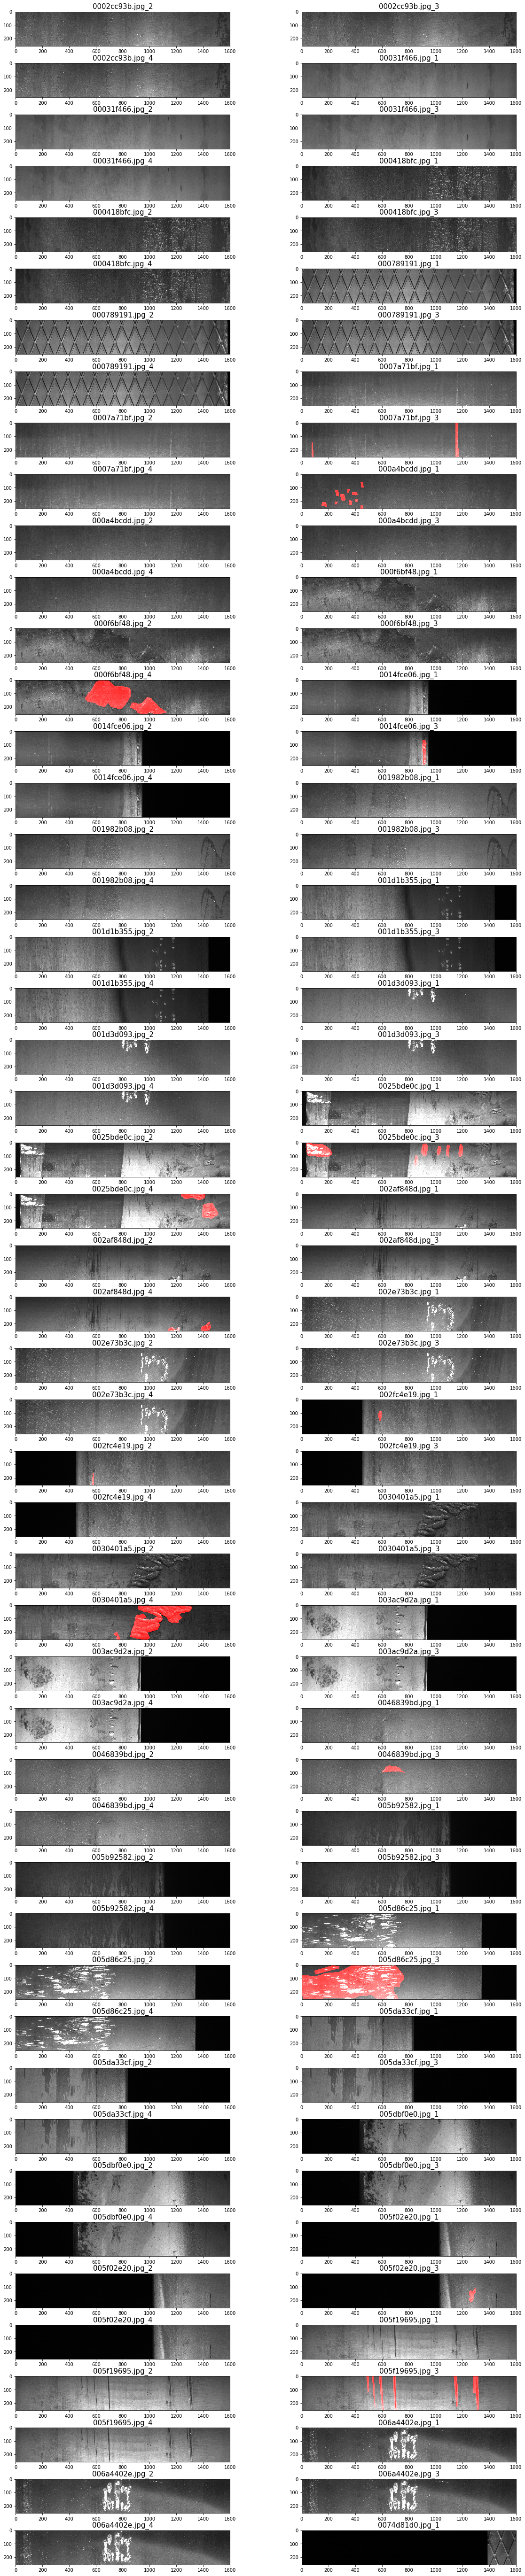

In [44]:
#Forked from Giba: https://www.kaggle.com/titericz/building-and-visualizing-masks
fig=plt.figure(figsize=(20,100))
columns = 2
rows = 50
fig.subplots_adjust(hspace=0.5)

for i in range(1, 100+1):
    fig.add_subplot(rows, columns, i)
    
    fn = details['ImageId_ClassId'].iloc[i].split('_')[0]
    img = cv2.imread( 'Train images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask( details['EncodedPixels'].iloc[i], img.shape  )
    img[mask==1,0] = 255
    
    plt.imshow(img)
    plt.title(details['ImageId_ClassId'].iloc[i], fontsize = 15)
plt.show()

Basically, need to train images using picture encoding in one line using cv2, and labels using the encodedPixels data opened up, as explained above. 

In [14]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def H(lst, name):
    x = concatenate(lst)
    num_filters = int(x.shape.as_list()[-1]/2)
    
    x = Conv2D(num_filters, (2, 2), padding='same', name=name)(x)
    x = BatchNormalization(name=name+'_bn')(x)
    x = LeakyReLU(alpha=0.1, name=name+'_activation')(x)
    
    return x

def U(x):
    num_filters = int(x.shape.as_list()[-1]/2)
    
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    return x

In [15]:
def EfficientUNet(input_shape):
    backbone = efn.EfficientNetB4(
        weights=None,
        include_top=False,
        input_shape=input_shape
    )
    
    backbone.load_weights(('../input/efficientnet-keras-weights-b0b5/'
                           'efficientnet-b4_imagenet_1000_notop.h5'))
    
    # Skipping block 4f and block 6h since they have the same output dim as 5f and 7b
    x00 = backbone.input  # (256, 512, 3)
    x10 = backbone.get_layer('stem_activation').output  # (128, 256, 4)
    x20 = backbone.get_layer('block2d_add').output  # (64, 128, 32)
    x30 = backbone.get_layer('block3d_add').output  # (32, 64, 56)
    x40 = backbone.get_layer('block5f_add').output  # (16, 32, 160)
    x50 = backbone.get_layer('block7b_add').output  # (8, 16, 448)
    
    x01 = H([x00, U(x10)], 'X01')
    x11 = H([x10, U(x20)], 'X11')
    x21 = H([x20, U(x30)], 'X21')
    x31 = H([x30, U(x40)], 'X31')
    x41 = H([x40, U(x50)], 'X41')
    
    x02 = H([x00, x01, U(x11)], 'X02')
    x12 = H([x11, U(x21)], 'X12')
    x22 = H([x21, U(x31)], 'X22')
    x32 = H([x31, U(x41)], 'X32')
    
    x03 = H([x00, x01, x02, U(x12)], 'X03')
    x13 = H([x12, U(x22)], 'X13')
    x23 = H([x22, U(x32)], 'X23')
    
    x04 = H([x00, x01, x02, x03, U(x13)], 'X04')
    x14 = H([x13, U(x23)], 'X14')
    
    x05 = H([x00, x01, x02, x03, x04, U(x14)], 'X05')
    
    x_out = Concatenate(name='bridge')([x01, x02, x03, x04, x05])
    x_out = Conv2D(4, (3,3), padding="same", name='final_output', activation="sigmoid")(x_out)
    
    return Model(inputs=x00, outputs=x_out)

In [ ]:
# load your data

x_train, y_train, x_val, y_val = load_data(...)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = Unet(BACKBONE, encoder_weights='imagenet')

model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

# fit model
model.fit(x=x_train,y=y_train,batch_size=16,epochs=100,validation_data=(x_val, y_val))